# ECE 276C HW3 P2
Mingwei Xu A53270271

In [1]:
import pickle
import gym
import pybulletgym.envs
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import MultivariateNormal

## Setup CUDA

In [2]:
# setup device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')    # CPU seems faster in this question
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cpu


## Define Network

In [3]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0] - 1   # should be 8 (TODO: bug in env showing wrong observation space?)
        self.action_space_n = env.action_space.shape[0]   # should be 2

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, self.action_space_n)

#         self.sigma = nn.Parameter(torch.eye(2))     # initalize cov matrix with grad fn
        self.sigma = nn.Parameter(torch.diag([0.2, 0.2]))

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # TODO: take sigma as input
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Tanh(),
            self.l2,
            nn.Tanh(),
            self.l3,
            nn.Tanh())

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [11]:
def choose_action(policy_network, state, eval_policy=False):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :param eval_policy: bool, flag to turn on when evaluating policy.
                        It will disable sample and return action directly from policy network output.
    :returns: list (len=2), action; tensor with grad fn, log probability
    """
    probs = policy_network.forward(state)   # mean from policy network output

    cov = torch.abs(policy_network.sigma) + 1e-3    # positive definite

    m = MultivariateNormal(probs, cov)
    action = m.sample()
    log_prob = m.log_prob(action)
    
    if eval_policy:
        print('action: ', probs)
        return probs.tolist(), log_prob

    return action.tolist(), log_prob

## Question 2

In [5]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

In [6]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode
    average_step_list = []

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []
        batch_log_prob_list = []
        batch_discounted_return_list = []
        batch_traj_steps = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_list = []
        traj_step_counter = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(1, len(traj_rewards) + 1)]

                # collect batch info
                batch_log_prob_list.extend(traj_log_prob_list)
                batch_discounted_return_list.extend(discounted_return_list)
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1
                batch_traj_steps.append(traj_step_counter)

                traj_step_counter = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        # subtract average returns if baseline is enabled
        if enable_baseline:
            batch_discounted_return_list -= np.mean(batch_discounted_return_list)
        
        # sum the traj loss by loop so we do not lose tensor gradient
        for step in range(len(batch_log_prob_list)):
            batch_loss_sum += batch_log_prob_list[step] * batch_discounted_return_list[step]
        
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        average_step_list.append(np.mean(batch_traj_steps))
        loss = - batch_loss_sum / batch_traj_counter    # TODO
        
        print('TODO: sigma: ', policy_network.sigma)    # TODO
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list, average_step_list

### Training

In [7]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
# TODO: test
state = env.reset()
print(state)

# setup network
policy_network = PolicyNetwork(env).to(device)
average_reward_list, average_step_list = reinforce_with_baseline(env, policy_network,batch_size=2000, num_episodes=500,
                                              lr=0.01, gamma=0.9, enable_baseline=True)

current_dir=/Users/xumw1996/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
options= 
[ 0.3928371   0.3928371  -0.68091764  0.26561381  0.5         0.
  0.08333333  0.        ]
TODO: sigma:  Parameter containing:
tensor([[1., 0.],
        [0., 1.]], requires_grad=True)
Episode [1/500] loss: 3.82, average reward: -55.79, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0100, 0.0000],
        [0.0000, 1.0100]], requires_grad=True)
Episode [2/500] loss: -2.08, average reward: -76.27, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0049, 0.0000],
        [0.0000, 1.0191]], requires_grad=True)
Episode [3/500] loss: 1.84, average reward: -80.79, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0031, 0.0000],
        [0.0000, 1.0273]], requires_grad=True)
Episode [4/500] loss: 2.12, average reward: -77.96, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0045, 0.0000],
        [0.0000, 1.0346]], requires_grad=True

TODO: sigma:  Parameter containing:
tensor([[1.0465, 0.0000],
        [0.0000, 1.0270]], requires_grad=True)
Episode [46/500] loss: -0.85, average reward: -86.45, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0500, 0.0000],
        [0.0000, 1.0240]], requires_grad=True)
Episode [47/500] loss: -1.81, average reward: -83.43, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0544, 0.0000],
        [0.0000, 1.0193]], requires_grad=True)
Episode [48/500] loss: -7.79, average reward: -81.17, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0580, 0.0000],
        [0.0000, 1.0126]], requires_grad=True)
Episode [49/500] loss: -2.15, average reward: -82.63, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0612, 0.0000],
        [0.0000, 1.0058]], requires_grad=True)
Episode [50/500] loss: -1.59, average reward: -77.58, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.0643, 0.0000],
        [0.0000, 0.9989]], r

TODO: sigma:  Parameter containing:
tensor([[1.0998, 0.0000],
        [0.0000, 0.8982]], requires_grad=True)
Episode [92/500] loss: 11.45, average reward: -81.27, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1021, 0.0000],
        [0.0000, 0.8981]], requires_grad=True)
Episode [93/500] loss: 0.65, average reward: -80.48, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1042, 0.0000],
        [0.0000, 0.8981]], requires_grad=True)
Episode [94/500] loss: 2.69, average reward: -79.44, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1073, 0.0000],
        [0.0000, 0.8977]], requires_grad=True)
Episode [95/500] loss: -3.96, average reward: -80.16, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1097, 0.0000],
        [0.0000, 0.8963]], requires_grad=True)
Episode [96/500] loss: -2.18, average reward: -75.51, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.1119, 0.0000],
        [0.0000, 0.8941]], req

TODO: sigma:  Parameter containing:
tensor([[1.0586, 0.0000],
        [0.0000, 0.8778]], requires_grad=True)
Episode [137/500] loss: -4.84, average reward: -80.47, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0562, 0.0000],
        [0.0000, 0.8792]], requires_grad=True)
Episode [138/500] loss: -5.96, average reward: -79.31, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0526, 0.0000],
        [0.0000, 0.8798]], requires_grad=True)
Episode [139/500] loss: -0.13, average reward: -79.95, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0494, 0.0000],
        [0.0000, 0.8802]], requires_grad=True)
Episode [140/500] loss: -3.61, average reward: -82.15, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0455, 0.0000],
        [0.0000, 0.8804]], requires_grad=True)
Episode [141/500] loss: 0.31, average reward: -79.20, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0416, 0.0000],
        [0.0000, 0.8811]

TODO: sigma:  Parameter containing:
tensor([[1.0522, 0.0000],
        [0.0000, 0.9961]], requires_grad=True)
Episode [182/500] loss: -2.97, average reward: -78.91, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.0546, 0.0000],
        [0.0000, 0.9959]], requires_grad=True)
Episode [183/500] loss: -1.04, average reward: -79.83, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0570, 0.0000],
        [0.0000, 0.9952]], requires_grad=True)
Episode [184/500] loss: -6.97, average reward: -86.08, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0574, 0.0000],
        [0.0000, 0.9939]], requires_grad=True)
Episode [185/500] loss: -0.67, average reward: -82.63, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0584, 0.0000],
        [0.0000, 0.9919]], requires_grad=True)
Episode [186/500] loss: -3.91, average reward: -81.15, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0593, 0.0000],
        [0.0000, 0.9888

TODO: sigma:  Parameter containing:
tensor([[1.1051, 0.0000],
        [0.0000, 0.9812]], requires_grad=True)
Episode [227/500] loss: 6.94, average reward: -83.15, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1073, 0.0000],
        [0.0000, 0.9799]], requires_grad=True)
Episode [228/500] loss: -0.69, average reward: -81.33, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1081, 0.0000],
        [0.0000, 0.9796]], requires_grad=True)
Episode [229/500] loss: -9.11, average reward: -85.47, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1075, 0.0000],
        [0.0000, 0.9777]], requires_grad=True)
Episode [230/500] loss: -2.30, average reward: -83.13, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1061, 0.0000],
        [0.0000, 0.9760]], requires_grad=True)
Episode [231/500] loss: 2.25, average reward: -81.52, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1051, 0.0000],
        [0.0000, 0.9751]]

TODO: sigma:  Parameter containing:
tensor([[1.1776, 0.0000],
        [0.0000, 0.9145]], requires_grad=True)
Episode [272/500] loss: -4.00, average reward: -84.26, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1787, 0.0000],
        [0.0000, 0.9120]], requires_grad=True)
Episode [273/500] loss: -3.35, average reward: -84.55, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1787, 0.0000],
        [0.0000, 0.9098]], requires_grad=True)
Episode [274/500] loss: -7.34, average reward: -85.28, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1777, 0.0000],
        [0.0000, 0.9063]], requires_grad=True)
Episode [275/500] loss: 0.13, average reward: -82.70, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1757, 0.0000],
        [0.0000, 0.9044]], requires_grad=True)
Episode [276/500] loss: 2.82, average reward: -83.09, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1740, 0.0000],
        [0.0000, 0.9038]]

TODO: sigma:  Parameter containing:
tensor([[1.2087, 0.0000],
        [0.0000, 0.9310]], requires_grad=True)
Episode [317/500] loss: -5.32, average reward: -84.02, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2049, 0.0000],
        [0.0000, 0.9333]], requires_grad=True)
Episode [318/500] loss: -2.62, average reward: -81.83, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2014, 0.0000],
        [0.0000, 0.9347]], requires_grad=True)
Episode [319/500] loss: 2.83, average reward: -83.96, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1983, 0.0000],
        [0.0000, 0.9368]], requires_grad=True)
Episode [320/500] loss: 0.02, average reward: -82.96, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1952, 0.0000],
        [0.0000, 0.9392]], requires_grad=True)
Episode [321/500] loss: 2.06, average reward: -83.98, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1932, 0.0000],
        [0.0000, 0.9410]],

TODO: sigma:  Parameter containing:
tensor([[1.1524, 0.0000],
        [0.0000, 0.8961]], requires_grad=True)
Episode [362/500] loss: -0.60, average reward: -82.86, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1544, 0.0000],
        [0.0000, 0.8934]], requires_grad=True)
Episode [363/500] loss: 4.67, average reward: -80.88, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1567, 0.0000],
        [0.0000, 0.8923]], requires_grad=True)
Episode [364/500] loss: 3.84, average reward: -84.40, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1585, 0.0000],
        [0.0000, 0.8930]], requires_grad=True)
Episode [365/500] loss: -0.99, average reward: -80.69, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1601, 0.0000],
        [0.0000, 0.8934]], requires_grad=True)
Episode [366/500] loss: 2.53, average reward: -80.64, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.1618, 0.0000],
        [0.0000, 0.8944]],

TODO: sigma:  Parameter containing:
tensor([[1.2211, 0.0000],
        [0.0000, 0.9929]], requires_grad=True)
Episode [407/500] loss: 1.02, average reward: -83.62, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2249, 0.0000],
        [0.0000, 0.9969]], requires_grad=True)
Episode [408/500] loss: -5.40, average reward: -84.22, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2275, 0.0000],
        [0.0000, 0.9997]], requires_grad=True)
Episode [409/500] loss: 2.24, average reward: -85.00, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2288, 0.0000],
        [0.0000, 1.0039]], requires_grad=True)
Episode [410/500] loss: 11.07, average reward: -86.69, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2308, 0.0000],
        [0.0000, 1.0105]], requires_grad=True)
Episode [411/500] loss: -3.46, average reward: -83.45, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2321, 0.0000],
        [0.0000, 1.0158]]

TODO: sigma:  Parameter containing:
tensor([[1.3011, 0.0000],
        [0.0000, 1.0273]], requires_grad=True)
Episode [452/500] loss: 2.23, average reward: -88.34, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.3012, 0.0000],
        [0.0000, 1.0252]], requires_grad=True)
Episode [453/500] loss: 0.90, average reward: -86.84, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.3011, 0.0000],
        [0.0000, 1.0238]], requires_grad=True)
Episode [454/500] loss: 6.85, average reward: -90.96, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.3007, 0.0000],
        [0.0000, 1.0251]], requires_grad=True)
Episode [455/500] loss: -0.78, average reward: -85.96, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.3002, 0.0000],
        [0.0000, 1.0262]], requires_grad=True)
Episode [456/500] loss: 3.42, average reward: -85.39, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2992, 0.0000],
        [0.0000, 1.0288]], 

TODO: sigma:  Parameter containing:
tensor([[1.2641, 0.0000],
        [0.0000, 0.9777]], requires_grad=True)
Episode [497/500] loss: -2.50, average reward: -80.72, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.2647, 0.0000],
        [0.0000, 0.9765]], requires_grad=True)
Episode [498/500] loss: -0.76, average reward: -80.21, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.2645, 0.0000],
        [0.0000, 0.9760]], requires_grad=True)
Episode [499/500] loss: -1.36, average reward: -86.66, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.2642, 0.0000],
        [0.0000, 0.9753]], requires_grad=True)
Episode [500/500] loss: -4.64, average reward: -85.34, trajectory num: 14


### Plot

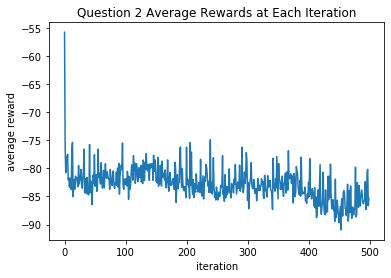

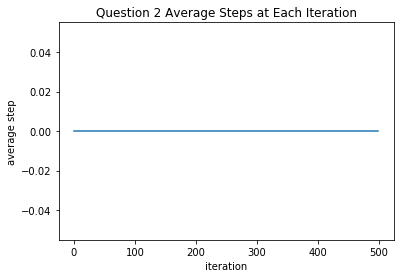

In [8]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 2 Average Rewards at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

plt.figure()
plt.plot(average_step_list)
plt.xlabel('iteration')
plt.ylabel('average step')
plt.title('Question 2 Average Steps at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

### Save Policy

In [9]:
with open('p2_policy.pkl', 'wb') as pickle_file:
    pickle.dump(policy_network, pickle_file)

## Test Policy

In [12]:
# load policy
# with open('p2_policy.pkl', 'rb') as pickle_file:
#     policy_network = pickle.load(pickle_file)

# test policy
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
state = env.reset()
done = False
steps = 0

while not done:
    # TODO: do not sample here
    action, log_prob = choose_action(policy_network, state, eval_policy=True)
    state_next, reward, done, _ = env.step(action)
    steps += 1

print('Finished in {} steps'.format(steps))

options= 
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([ 1.0000, -1.0